In [1]:
import sys
import os
from easydict import EasyDict

import h5py

import json
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

from torch2trt import torch2trt

from alphapose.models import builder
from alphapose.utils.config import update_config
from alphapose.utils.transforms import get_func_heatmap_to_coord
from alphapose.utils.bbox import (_box_to_center_scale, _center_scale_to_box)
from alphapose.utils.transforms import (get_affine_transform, im_to_torch)
from detector.yolo4_csp.ScaledYOLOv4.utils.torch_utils import time_synchronized
from torch2trt import TRTModule

In [2]:
sys.path.append('./detector/')
sys.path.append('./detector/yolo4_csp/ScaledYOLOv4/')
sys.path.append('./detector/yolo/')

In [3]:
cfg = update_config('./pretrained_models/fastpose/256x192_res50_lr1e-3_full/256x192_res50_lr1e-3_full.yaml')
cfg.MODEL.TRY_LOAD='./pretrained_models/fastpose/256x192_res50_lr1e-3_full/256x192_res50_lr1e-3_full.pth'

In [4]:
from detector.yolo4_api import YOLO4Detector
from detector.yolo4trt_api import YOLO4TRTDetector
from detector.yolo4_cfg import cfg as yolo_cfg
from detector.yolo4_csp.preprocess import prep_image

In [5]:
class Transform(object):
    """Generation of cropped input person and pose heatmaps from SimplePose.

    Parameters
    ----------
    input_size: tuple
        Input image size, as (height, width).
    output_size: tuple
        Heatmap size, as (height, width).
    """

    def __init__(self,input_size, output_size, gpu_device='cuda'):
        self._gpu_device = gpu_device

        self._input_size = input_size
        self._heatmap_size = output_size

        self._aspect_ratio = float(input_size[1]) / input_size[0]  # w / h
        
    def preprocess(self, src, bbox):
        x, y, w, h = bbox
        center, scale = _box_to_center_scale(
            x, y, w, h, self._aspect_ratio)
        scale = scale * 1.0

        input_size = self._input_size
        inp_h, inp_w = input_size

        trans = get_affine_transform(center, scale, 0, [inp_w, inp_h])
        img = cv2.warpAffine(src, trans, (int(inp_w), int(inp_h)), flags=cv2.INTER_LINEAR)
        bbox = _center_scale_to_box(center, scale)
        
        return img, bbox
        

    def transform(self, src, bbox):
        x, y, w, h = bbox
        center, scale = _box_to_center_scale(
            x, y, w, h, self._aspect_ratio)
        scale = scale * 1.0

        input_size = self._input_size
        inp_h, inp_w = input_size

        trans = get_affine_transform(center, scale, 0, [inp_w, inp_h])
        img = cv2.warpAffine(src, trans, (int(inp_w), int(inp_h)), flags=cv2.INTER_LINEAR)
        bbox = _center_scale_to_box(center, scale)

        img = im_to_torch(img)
        img[0].add_(-0.406)
        img[1].add_(-0.457)
        img[2].add_(-0.480)

        return img, bbox

In [6]:
yolo_opt = EasyDict()
yolo_opt.gpus = [i for i in range(torch.cuda.device_count())]
yolo_opt.device = torch.device("cuda:" + str(yolo_opt.gpus[0]) if yolo_opt.gpus[0] >= 0 else "cpu")

In [7]:
trans=Transform(cfg.DATA_PRESET.IMAGE_SIZE, cfg.DATA_PRESET.HEATMAP_SIZE)

In [8]:
imgfolder ='/home/taoshaf/Datasets/c2f-vol-train/data/h36m/images/'
imgnames = sorted(os.listdir(imgfolder))
imgnames =[imgname for imgname in imgnames if imgname.endswith('.jpg') and ('S11_' in imgname or 'S9_' in imgname)]

In [9]:
imgfolder = '/home/taoshaf/Datasets/3DPW/imageFiles/outdoors_fencing_01/'
imgnames = sorted(os.listdir(imgfolder))
imgnames =[imgname for imgname in imgnames if imgname.endswith('.jpg')]

In [10]:
detect_trt = YOLO4TRTDetector(yolo_cfg, yolo_opt)
detect_trt.load_model_trt('./pretrained_models/tensorrt/yolo_csp_trt.pth')
detect_trt.model.eval()
print('YOLO4-CSP loaded')

TensorRT network created
YOLO4-CSP loaded


In [11]:
model_trt = TRTModule()
model_trt.load_state_dict(torch.load('./pretrained_models/tensorrt/256x192_res50_full_trt_fp16.pth'))
model_trt.eval()
print('AlphaPose loaded')

AlphaPose loaded


In [12]:
heatmap_to_coord = get_func_heatmap_to_coord(cfg)
norm_type = cfg.LOSS.get('NORM_TYPE', None)
hm_size = cfg.DATA_PRESET.HEATMAP_SIZE

In [13]:
total = 0
res_rt = dict()
with torch.no_grad():
    for (i, imgname) in enumerate(imgnames[:1000]):
#     for (i, imgname) in enumerate(imgnames[40489:40800]):
        imgfile = os.path.join(imgfolder, imgname)
        img = cv2.imread(imgfile)
        t1 = time_synchronized()
        bbox = detect_trt.detect_one_frame(0,img)
        
        if not bbox:
            continue
        bbox = bbox[0]['bbox']
        im, box = trans.transform(img[:,:,::-1], bbox)
        im=im.unsqueeze(0).cuda()
        output = model_trt(im)
        kpts_rt = np.hstack(heatmap_to_coord(output[0],box,hm_shape=hm_size, norm_type=norm_type))
        t2 = time_synchronized()
        total += t2-t1
        res_rt[imgname[:-4]] = kpts_rt.astype(np.float64)
        if i%100 == 0:
            print(total/(i+1))

0.04508566856384277
0.038174412038066596
0.037463971038362874
0.037224117703612065
0.0371028271101954
0.037030921010913966
0.03693944562889772
0.03687350147971073
0.03681778431534023
0.03677011726963666


In [14]:
import matplotlib.pyplot as plt

In [15]:
keys = list(res_rt.keys())
vals = list(res_rt.values())

In [16]:
index = 750
imgname = keys[index]+'.jpg'
kpts = np.array(vals[index])
img = cv2.imread(os.path.join(imgfolder, imgname))

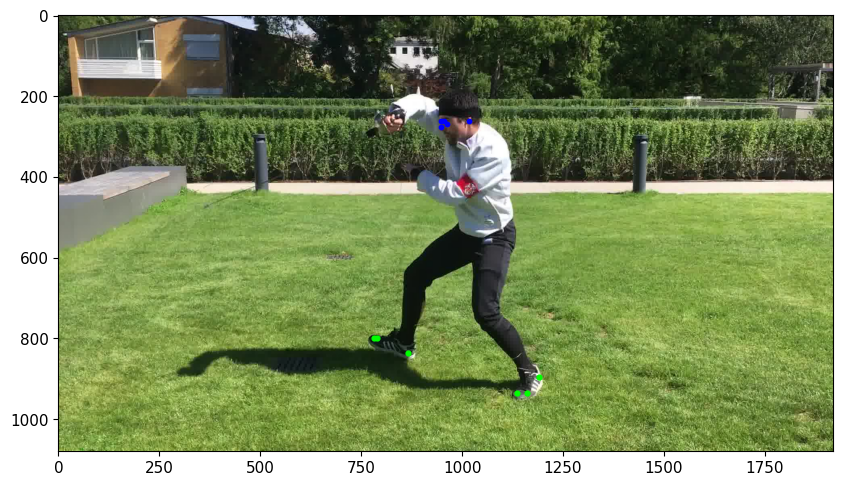

In [17]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(img[:,:,::-1])
sel= list(range(0,5))
plt.scatter(kpts[sel,0], kpts[sel,1], s=10, color='blue')
sel = 2
# plt.scatter(kpts[sel,0], kpts[sel,1], s=10, color='red')

# plt.scatter(kpts[:,0],kpts[:,1],s=10)
# sel=list(range(2,8,2))
# plt.scatter(kpts[sel,0],kpts[sel,1],s=12,color='blue')
# sel=list(range(3,8,2))
# plt.scatter(kpts[sel,0],kpts[sel,1],s=12,color='yellow')
# sel=list(range(8,14,2))
# plt.scatter(kpts[sel,0],kpts[sel,1],s=12,color='purple')
# sel=list(range(9,14,2))
# plt.scatter(kpts[sel,0],kpts[sel,1],s=12,color='lime')
# sel=list(range(14,17,1))
# plt.scatter(kpts[sel,0],kpts[sel,1],s=12,color='c')
# sel=list(range(17,19,1))
# plt.scatter(kpts[sel,0],kpts[sel,1],s=12,color='red')
sel=list(range(20,26,1))
plt.scatter(kpts[sel,0],kpts[sel,1],s=12,color='lime')

In [21]:
keypoints = [keypoint.tolist() for keypoint in vals]

In [25]:
with open('./fencing_keypoints.json', 'w') as file:
    json.dump(keypoints,file)

In [26]:
len(keypoints)

942